In [9]:
#Imports
import os
import logging
import warnings
from matplotlib import pyplot as plt #type: ignore
import pandas as pd #type: ignore
from sklearn.model_selection import train_test_split #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.metrics import roc_curve, auc #type: ignore
import tensorflow as tf #type: ignore
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Dense, Dropout #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report #type: ignore
import json


In [10]:
#Esconder mensagens desnecessárias
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


#Caminho para o banco de dados
file_path = r'/home/l1nc0n/Documentos/projetos/Neural_breast/data.csv'
data = pd.read_csv(file_path)


#Verificação de dados ausentes
print("Dados ausentes por coluna:")
print(data.isnull().sum())


#Remover colunas desnecessárias
if 'Unnamed: 32' in data.columns:
    data = data.drop(columns=['Unnamed: 32'])
if 'id' in data.columns:
    ids = data['id']  
    data = data.drop(columns=['id'])


#Convertendo o diagnosis para valores 0 e 1, indicando Maligno e Benigno
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})


#Tratamento
if data.isnull().sum().sum() > 0:
    data = data.dropna()


#Divisão dos dados em características X e Y
X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

Dados ausentes por coluna:
id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dime

In [11]:
#Solicitar ao usuário o tamanho do conjunto de teste para a rede neural (Finalidade de realizar 10 testes para verificarmos sua melhoria)
while True:
    try:
        test_size = float(input("Escolha o conjunto para treinamento (Valores entre 0 e 1): "))
        if 0 < test_size < 1:
            break
        else:
            print("Insira um valor entre 0 e 1.")
    except ValueError:
        print("Valor inválido.")


Modelo de treinamento:

In [ ]:
#Dividindo os dados para treino da rede
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


#Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)  # Todos os dados escalados


#Modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


#Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])


#Callback para parada antecipada caso o modelo não melhore o resultado nas últimas 10 iterações (Resultados parecidos) 
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


#Treinamento do modelo com 500 épocas para treino (Acreditamos ser o suficiente neste contexto)
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, batch_size=32, verbose=1, callbacks=[])


#Rodar o modelo treinado em cima de TODOS OS DADOS (sem divisão de treino/teste)
y_pred_all = (model.predict(X_scaled) > 0.5).astype("int32")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
Acurácia no conjunto de teste: 0.9715
AUC no conjunto de teste: 0.9906


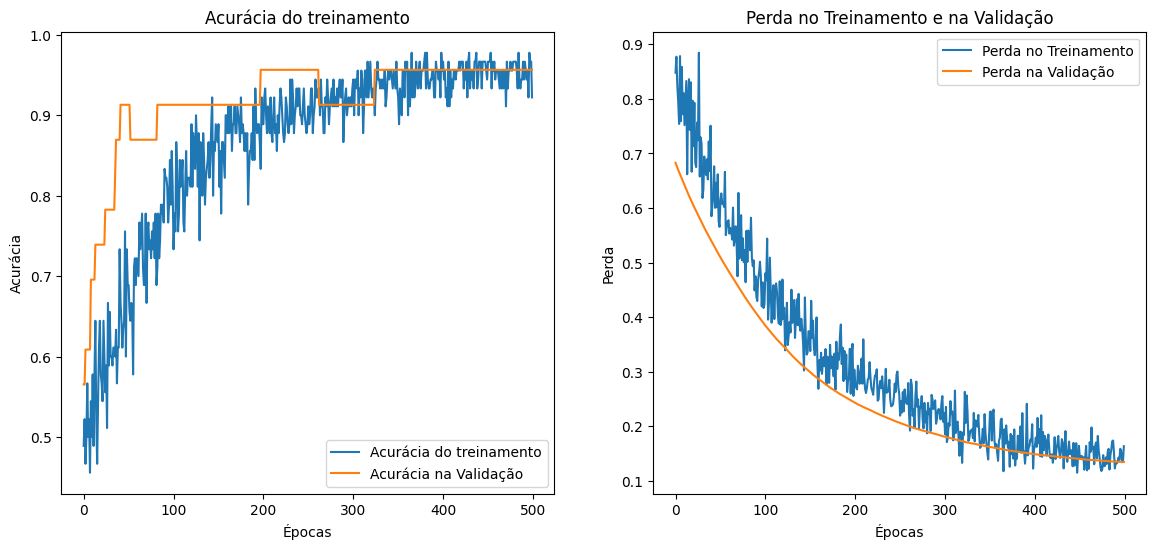

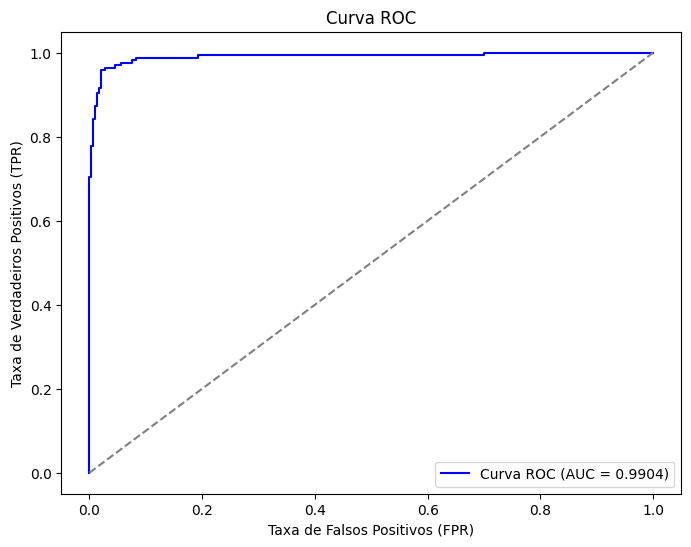

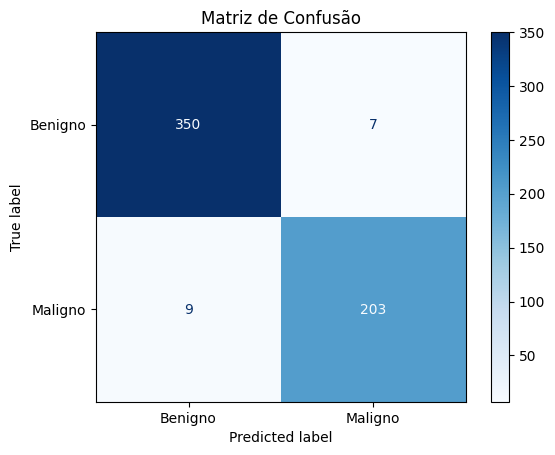

In [13]:

#Avaliando o modelo com o conjunto de teste
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)
y_pred_prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f'Acurácia no conjunto de teste: {test_accuracy:.4f}')
print(f'AUC no conjunto de teste: {test_auc:.4f}')


#Gráfico da acurácia
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia do treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia do treinamento')


#Gráfico da Perda no treinamento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda no Treinamento')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda no Treinamento e na Validação')
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


#Gráfico da Matriz de confusão
cm_all = confusion_matrix(y, y_pred_all)
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=['Benigno', 'Maligno'])
disp_all.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()




In [14]:

#Relatório de classificação
classification_report_all = classification_report(y, y_pred_all, target_names=['Benigno', 'Maligno'], output_dict=True)
print("Relatório de Classificação:")
print(classification_report(y, y_pred_all, target_names=['Benigno', 'Maligno']))


#Informações para o JSON
results = {
    "test_evaluation": {
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "test_auc": test_auc,
        "classification_report": classification_report_all 
    },
    "all_data_evaluation": {
        "classification_report_all": classification_report_all,
        "confusion_matrix_all": cm_all.tolist()  
    }
}


#Caminho arquivo JSON
results_file_path = 'resultados.json'


#Carregar os resultados existentes e adicionar novos resultados encontrados (Informações para o artigo)
if os.path.exists(results_file_path):
    with open(results_file_path, 'r') as json_file:
        existing_results = json.load(json_file)
else:
    existing_results = []


#Adicionar os novos resultados da execução
existing_results.append(results)


#Salvar os resultados atualizados no JSON
with open(results_file_path, 'w') as json_file:
    json.dump(existing_results, json_file, indent=4)



print(f"Resultados salvos em: {results_file_path}")

Relatório de Classificação:
              precision    recall  f1-score   support

     Benigno       0.97      0.98      0.98       357
     Maligno       0.97      0.96      0.96       212

    accuracy                           0.97       569
   macro avg       0.97      0.97      0.97       569
weighted avg       0.97      0.97      0.97       569

Resultados salvos em: resultados.json
